# Quick Start

This section provides an introduction to using `PetroFit`. 
It also highlights essential functions in conjunction with `Photutils` and `Astropy`. 
For in-depth explanations, refer to the respective sections of interest within this documentation.

To start with `PetroFit`, simply import it as follows:

In [1]:
import petrofit as pf

## Loading Example Data

The following data is a cutout of a group of bright galaxies in Abell 2744 (located at `(3.596248, -30.388517)`). The original data was acquired by the [Hubble Frontier Fields](https://frontierfields.org) team via the WFC3 instrument in the `F105W` filter and can be directly downloaded from the [Mikulski Archive for Space Telescopes](https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0/hlsp_frontier_hst_wfc3-60mas_abell2744_f105w_v1.0_drz.fits). The cutout image used in this documentation can be found in the git repository at the following path `petrofit/docs/data/abell_2744_dwarf_galaxy_f105w.fits.gz`.

### Loading Image 
You can use `astropy`'s ``CCDData`` to load the example data and visualize it through `matplotlib`. Note that ``CCDData.read`` does not return a 2D array, but rather a ``CCDData`` instance which contains the image array, header, and WCS. To access the image array stored in the ``CCDData`` use the ``data`` attribute (i.e ``CCDData.data`` as shown in the ``plt.imshow`` command below).

In [2]:
from astropy.nddata import CCDData

image = CCDData.read('data/abell_2744_dwarf_galaxy_f105w.fits.gz')

In [3]:
# Hidden cell

%matplotlib inline

# Stop Fit Model to Data section warnings
import warnings
warnings.filterwarnings('ignore', append=True)

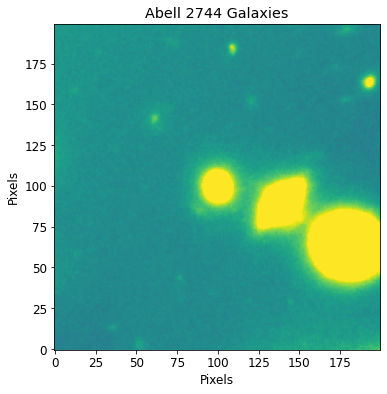

In [39]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['font.size'] = 12

vmax = 0.05 # vmax for matplotlib imshow
vmin = - vmax 

plt.imshow(image.data, vmin=vmin, vmax=vmax)
plt.title("Abell 2744 Galaxies")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

### Loading RMS Image
Since we only want the rms image array, we use `astropy`'s ``io.fits.getdata`` function as follows:

In [5]:
from astropy.io import fits 
rms = fits.getdata('data/abell_2744_dwarf_galaxy_f105w_rms.fits.gz')

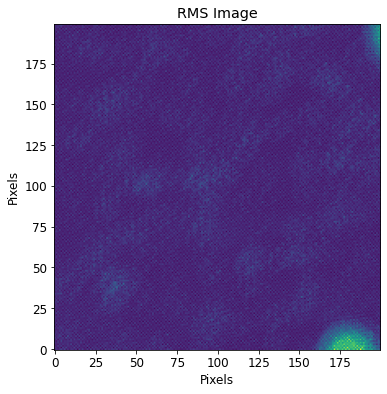

In [6]:
plt.imshow(rms)
plt.title("RMS Image")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

### Making Cutouts

You can use `astropy`'s `Cutout2D` function to make cutouts of sources. To access the data (image array), use the ``data`` attribute (i.e ``Cutout2D.data`` as shown in the ``plt.imshow`` command below). Note that ``position`` can be a `SkyCoord` if you provide the `Cutout2D` function a WCS.

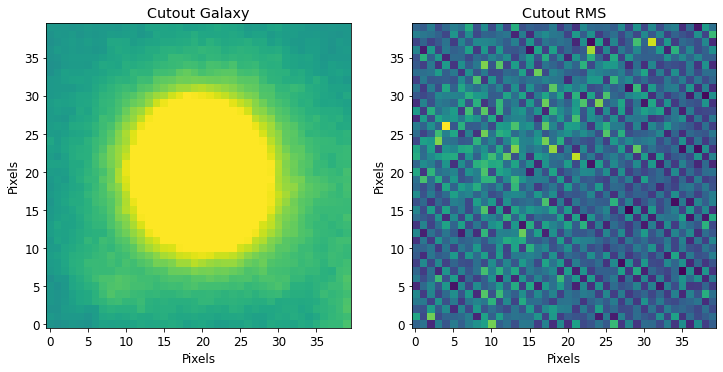

In [7]:
from astropy.nddata import Cutout2D

# Make cutout image, centerd at (100, 100) pixels, 40 pixels in size
cutout_image = Cutout2D(image, position=(100,100), size=40)

# Make cutout rms, centerd at (100, 100) pixels, 40 pixels in size
cutout_rms = Cutout2D(rms, position=(100,100), size=40)

# Plot cutouts
# ------------
fig, axs = plt.subplots(1,2, figsize=(12, 6))

plt.sca(axs[0])
plt.imshow(cutout_image.data, vmin=vmin, vmax=vmax)
plt.title("Cutout Galaxy")
plt.xlabel("Pixels")
plt.ylabel("Pixels")

plt.sca(axs[1])
plt.imshow(cutout_rms.data)
plt.title("Cutout RMS")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

## Defining AstroPy Sérsic Models

This example shows how to define a 2D Sérsic model using `astropy`. We fill in our initial guess for the parameters (or correct parameters if we know them) when initializing the ``Sersic2D`` object. 

To assist users, PetroFit offers a function named `get_default_sersic_bounds` that provides a default set of bounds for the Sérsic model parameters. This function is particularly useful when you're fitting data as these bounds help in constraining the fitting parameter space. 

The dictionary returned by `get_default_sersic_bounds` has parameter names as its keys. The values are tuples where the first element indicates the minimum allowed value and the second element indicates the maximum. In situations where there's no constraint on a parameter's value, `None` is used.

For instance, the dictionary looks like this:


```python
# get_default_sersic_bounds returns:
bounds = {
    'amplitude': (0., None),
    'r_eff': (0, None),
    'n': (0, 10),
    'ellip': (0, 1),
    'theta': (-2 * np.pi, 2 * np.pi),
}
```

In [8]:
from astropy.modeling import models

sersic_model = models.Sersic2D(

        amplitude=10, # Intensity at r_eff
        r_eff=1, # Effective or half-lilght radius
        n=4, # Sersic index
        x_0=20, # center of model in the x direction
        y_0=20, # center of model in the y direction
        ellip=0.1, # Ellipticity
        theta=0.0, # Rotation angle in radians, counterclockwise from the positive x-axis.
    
        bounds=pf.get_default_sersic_bounds(), # PetroFit parameter bounds
)

To add `x_0` and `y_0` bounds to the default bounds, you can update the dictionary as you would a regular Python dictionary. You can add or update bounds by passing a Python dictionary to the `get_default_sersic_bounds` function as follows:

In [9]:
bound_dict = pf.get_default_sersic_bounds({
    'x_0': (10, 30),  
    'y_0': (10, 30)})
bound_dict

{'amplitude': (0.0, None),
 'r_eff': (0.001, None),
 'n': (0.1, 10),
 'ellip': (0, 0.99),
 'theta': (-6.283185307179586, 6.283185307179586),
 'x_0': (10, 30),
 'y_0': (10, 30)}

You can also directly update the model bounds as follows:

In [10]:
sersic_model.bounds.update({'x_0': (10, 30),  'y_0': (10, 30)})

## Making Compound Models (Combining Models)

You can combine multiple models to form a compound model by adding, subtracting, multiplying, and dividing individual models. For example, we add the Sérsic model from the last section to itself to form a two-component Sérsic model (notice that the number of parameters double):

In [11]:
compound_sersic_model = sersic_model + sersic_model

In [12]:
pf.print_model_params(compound_sersic_model)

10.0000	amplitude_0
1.0000	r_eff_0
4.0000	n_0
20.0000	x_0_0
20.0000	y_0_0
0.1000	ellip_0
0.0000	theta_0
10.0000	amplitude_1
1.0000	r_eff_1
4.0000	n_1
20.0000	x_0_1
20.0000	y_0_1
0.1000	ellip_1
0.0000	theta_1


## Making a PSF Convolved Model

`PSFConvolvedModel2D` is an extension of `Fittable2DModel` designed to incorporate PSF convolution and facilitate image sampling for models native to `astropy`. This model functions by:

1. Generating an image representation of the base model.
2. Sampling this image onto a defined grid.
3. If supplied, convolving the model image with a PSF.

Because `PSFConvolvedModel2D` retains the properties of a `Fittable2DModel`, it can be used for fitting model-generated images against actual data. 
As an illustration, this documentation will demonstrate the usage of `PSFConvolvedModel2D` with `astropy`'s `Sersic2D` model we defined above.


PSF Shape = (50, 50)


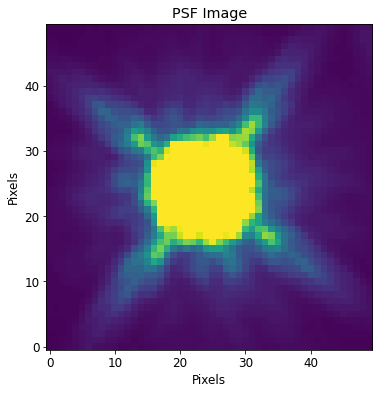

In [13]:
# Load PSF image (2D array)
PSF = fits.getdata('data/f105w_psf.fits.gz')

# Normalize PSF 
PSF = PSF / PSF.sum()

# Note that the PSF shape is odd on all sides
print("PSF Shape = {}".format(PSF.shape))

# Plot PSF and use vmax and vmin to show difraction spikes
plt.imshow(PSF, vmin=0, vmax=PSF.std()/10)
plt.title("PSF Image")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

In [14]:
# PSFConvolvedModel2D 
psf_sersic_model = pf.PSFConvolvedModel2D(sersic_model, psf=PSF, oversample=4)

## Converting Models to Images

To convert any 2D model (Astropy or PetroFit) to an image use the `model_to_image` function.

In [15]:
# Size of model image
size = 40

# sersic model image
model_image = pf.model_to_image(model=sersic_model, size=size)

# PSF convolved model image 
psf_model_image = pf.model_to_image(model=psf_sersic_model, size=size)

Plot model image

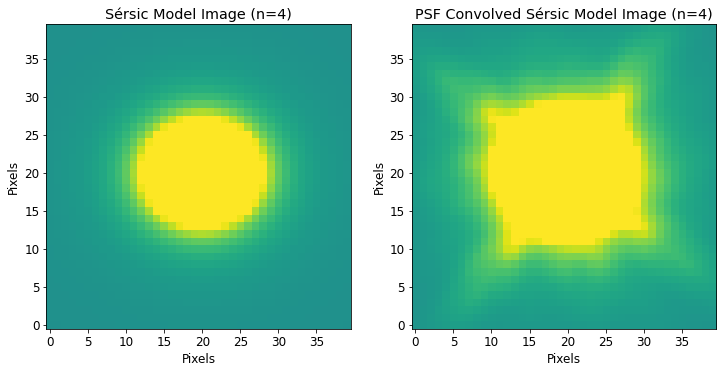

In [16]:
fig, axs = plt.subplots(1,2, figsize=(12, 6))

plt.sca(axs[0])
plt.imshow(model_image, vmin=vmin, vmax=vmax)
plt.title('Sérsic Model Image (n=4)')
plt.xlabel("Pixels")
plt.ylabel("Pixels")

plt.sca(axs[1])
plt.imshow(psf_model_image, vmin=vmin, vmax=vmax)
plt.title('PSF Convolved Sérsic Model Image (n=4)')
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

## Fitting Model to Image

We first define a `PSFConvolvedModel2D` model with initial guesses as follows:

In [17]:
sersic_model = models.Sersic2D(
        amplitude=0.1, # Intensity at r_eff
        r_eff=10, # Effective or half-lilght radius
        n=1, # Sersic index
        x_0=20, # center of model in the x direction
        y_0=20, # center of model in the y direction
        ellip=0.1, # Ellipticity
        theta=0.0, # Rotation angle in radians, counterclockwise from the positive x-axis.
    
        bounds=pf.get_default_sersic_bounds({'x_0': (10, 30),  'y_0': (10, 30)}), # Parameter bounds
)

psf_sersic_model = pf.PSFConvolvedModel2D(sersic_model, psf=PSF, oversample=4)

Before we fit the image, we compute the weights of each pixel using rms data as follows (please note that weights are optional and set to `None` by default):

In [18]:
fitting_weights = 1 / cutout_rms.data 

Use the `fit_model` function to fit 2D models to images as follows:

In [19]:
%%time

fitted_model, fitter = pf.fit_model(
    image=cutout_image.data, 
    model=psf_sersic_model,
    weights=fitting_weights, 
    maxiter=10000,
    epsilon=1.4901161193847656e-08,
    acc=1e-09,
)

CPU times: user 1.26 s, sys: 463 ms, total: 1.73 s
Wall time: 312 ms


Convert the fitted model into an image

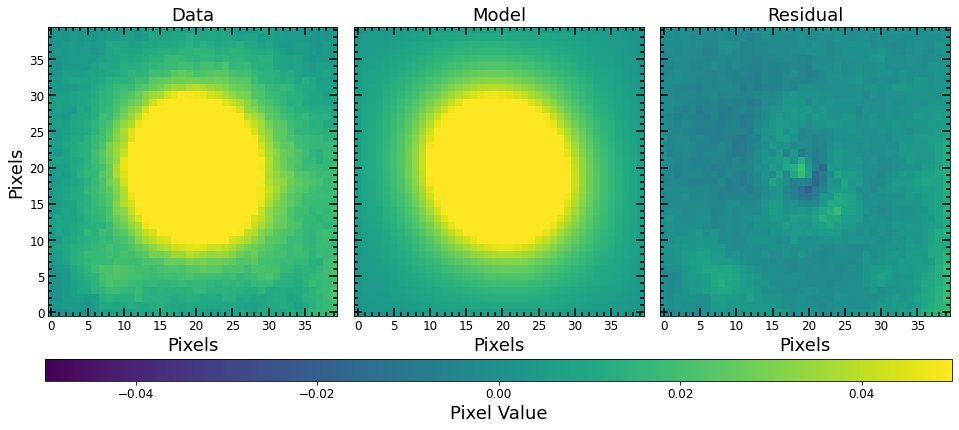

In [40]:
axs, cbar, model_image, residual_image = pf.plot_fit(fitted_model, cutout_image, 
                                                     vmax=vmax, vmin=vmin, figsize=[6*3, 6])
    
plt.show()

## Fitting Multiple Sources

If the locations of the sources are known, we can fit all sources at the same time by creating a compound model. Note that `x_0` and `y_0` are known beforehand using photometric centroids. Below, a compound model of 3 Sérsic components is defined and the original image is fit (i.e not the cutout we have been working with).


In [21]:
# Center elliptical galaxy we have been fitting:
galaxy_model_1 = models.Sersic2D(

        amplitude=0.1, # Intensity at r_eff
        r_eff=10, # Effective or half-lilght radius
        n=1.7384901, # Sersic index
        x_0=99.97722657736085, # center of model in the x direction
        y_0=99.12324178530918, # center of model in the y direction
        ellip=0.1, # Ellipticity
        theta=0.0, # Rotation angle in radians, counterclockwise from the positive x-axis.

        bounds=pf.get_default_sersic_bounds(), # Parameter bounds
) 

# Football shaped galaxy 
galaxy_model_2 = models.Sersic2D(

        amplitude=0.1, # Intensity at r_eff
        r_eff=10, # Effective or half-lilght radius
        n=1, # Sersic index
        x_0=138.56315299695075, # center of model in the x direction
        y_0=89.27757468116197, # center of model in the y direction
        ellip=0.7, # Ellipticity
        theta=0.7, # Rotation angle in radians, counterclockwise from the positive x-axis.

        bounds=pf.get_default_sersic_bounds(), # Parameter bounds
)

# Large galaxy near the bottom corner 
galaxy_model_3 = models.Sersic2D(

        amplitude=0.1, # Intensity at r_eff
        r_eff=10, # Effective or half-lilght radius
        n=1, # Sersic index
        x_0=178.72302596615611, # center of model in the x direction
        y_0=63.506754312433046	, # center of model in the y direction
        ellip=0.2, # Ellipticity
        theta=0.0, # Rotation angle in radians, counterclockwise from the positive x-axis.

        bounds=pf.get_default_sersic_bounds(), # Parameter bounds
) 

Make compound PSF model as follows:

In [22]:
compound_galaxies_model = galaxy_model_1 + galaxy_model_2 + galaxy_model_3

all_galaxies_psf_model = pf.PSFConvolvedModel2D(compound_galaxies_model, psf=PSF)

Fit the model 

In [23]:
%%time

all_galaxies_fitted_model, fitter = pf.fit_model(
    image=image.data, 
    model=all_galaxies_psf_model,
    weights=1/rms, # optional 
    maxiter=10000,
    epsilon=1.4901161193847656e-08,
    acc=1e-09,
)

CPU times: user 17.5 s, sys: 7.3 s, total: 24.8 s
Wall time: 4.01 s


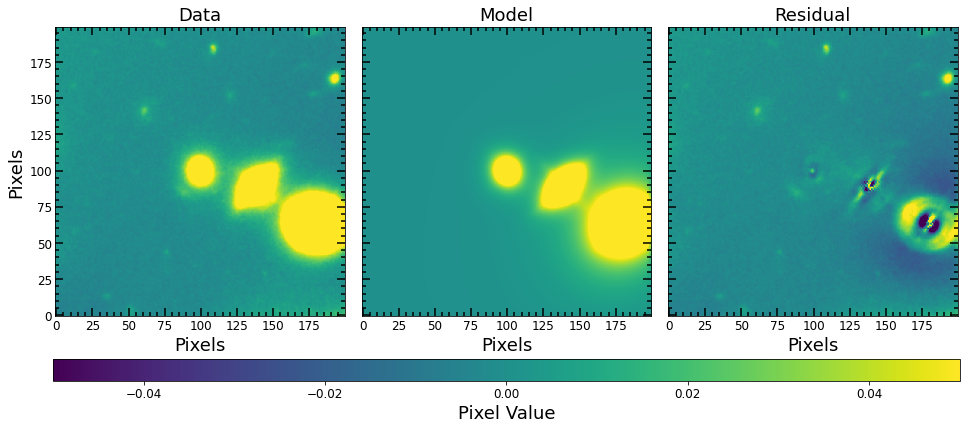

In [24]:
pf.plot_fit(all_galaxies_fitted_model, image, vmax=vmax, vmin=vmin, figsize=[6*3, 6])
plt.show()

Looks like the bottom corner galaxy is a spiral, let us add another component for the spiral and use `LevMarLSQFitter` to  fit again:

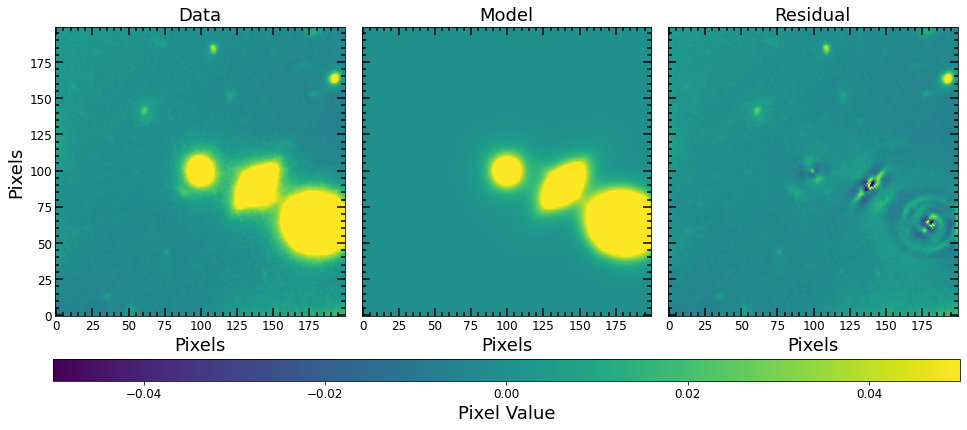

CPU times: user 15 s, sys: 154 ms, total: 15.1 s
Wall time: 14.9 s


In [25]:
%%time
from astropy.modeling import fitting

# Redefine model with an extra component for galaxy 3 
compound_galaxies_model = galaxy_model_1 + galaxy_model_2 + galaxy_model_3 + galaxy_model_3

# PSF model
all_galaxies_psf_model = pf.PSFConvolvedModel2D(compound_galaxies_model, psf=PSF)

# Fit the model
all_galaxies_fitted_model, fitter = pf.fit_model(
    image=image.data, 
    model=all_galaxies_psf_model,
    weights=1/rms, # optional
    maxiter=100000,
    fitter=fitting.LevMarLSQFitter,
    epsilon=1.4901161193847656e-08,
    acc=1e-09,
)

# Plot the fit
pf.plot_fit(all_galaxies_fitted_model, image, vmax=vmax, vmin=vmin, figsize=[6*3, 6])
plt.show()

## Fitting Image Backgrounds 

The `fit_background` function can be used to fit the background pixels using a 2D plane. It will sigma clip the pixels (sigma value provided by the user) and fit a 2D plane to the clipped image. Users can also provide their own 2D models.

In [26]:
bg_model, fitter = pf.fit_background(image, sigma=3.0)
bg_image = pf.model_to_image(bg_model, size=(image.shape[1], image.shape[0]))

Plot backround

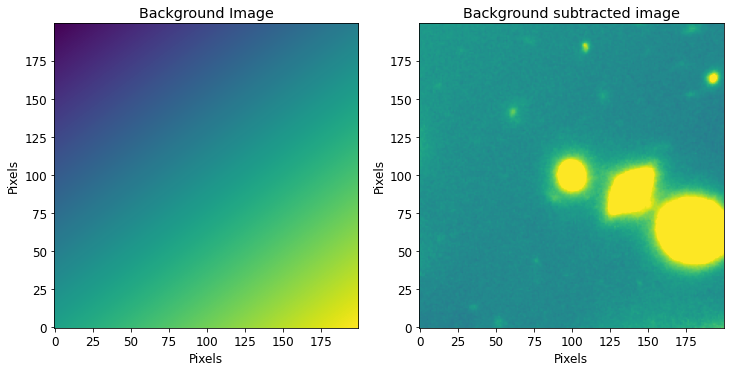

In [27]:
fig, axs = plt.subplots(1,2, figsize=[6*2, 6])

plt.sca(axs[0])
plt.imshow(bg_image)
plt.title("Background Image")
plt.xlabel("Pixels")
plt.ylabel("Pixels")

plt.sca(axs[1])
plt.imshow(image.data - bg_image, vmin=vmin, vmax=vmax)
plt.title("Background subtracted image")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

## Fitting a PSF With a Moffat Model

In this example we fit the PSF itself, from [the section above](#Making-a-PSF-Convolved-Model), using an `astropy` 2D Moffat model (PSF convolution is not needed for such fits). We then use the model PSF to fit the cutout image from the [Making Cutouts section](#Making-Cutouts). We start by initializing a `Moffat2D` model:

In [28]:
moffat_model = models.Moffat2D(amplitude=1, x_0=25, y_0=25, gamma=1, alpha=1)

Fit the model using ``fit_model``:

In [29]:
%%time

fitted_moffat_model, fitter = pf.fit_model(
    image=PSF, 
    model=moffat_model,
    weights=None, # optional 
    maxiter=10000,
    epsilon=1.4901161193847656e-08,
    acc=1e-09,
)

CPU times: user 35.7 ms, sys: 13.7 ms, total: 49.4 ms
Wall time: 11.9 ms


Plot the fit and print out fitted parameters:

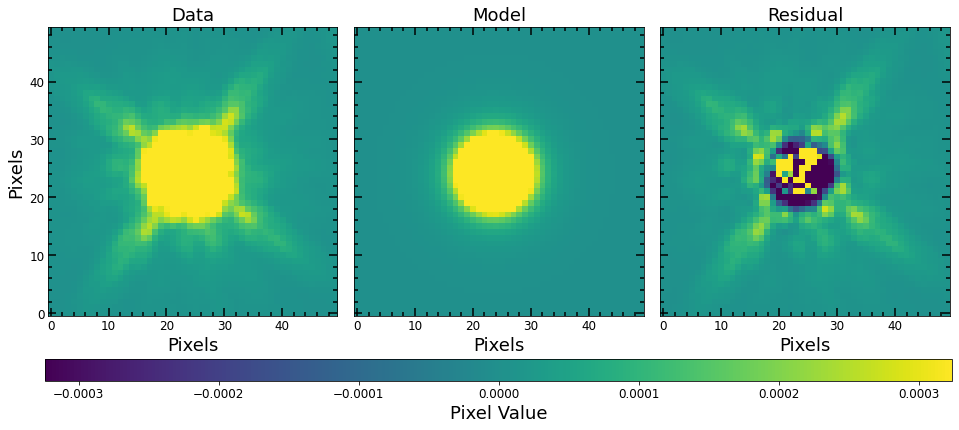

Fitted Moffat Params:
0.0780	amplitude
23.6932	x_0
24.0988	y_0
2.2447	gamma
2.3227	alpha


In [30]:
psf_vmax = PSF.std()/10
psf_vmin = -psf_vmax
pf.plot_fit(fitted_moffat_model, PSF, vmin=psf_vmin, vmax=psf_vmax, figsize=[6*3, 6])
plt.show()

print("Fitted Moffat Params:")
pf.print_model_params(fitted_moffat_model)

Use the fitted Moffat model as a PSF and fit a galaxy:

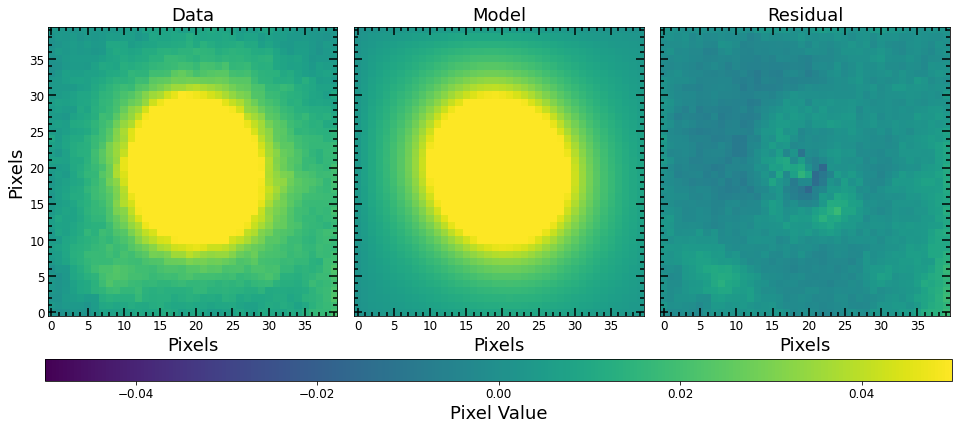

In [31]:
# Make Moffat PSF 
moffat_model_psf = pf.model_to_image(fitted_moffat_model, size=(51, 51))

# Make a PSFConvolvedModel2D model with Moffat PSF 
moffat_psf_sersic_model = pf.PSFConvolvedModel2D(
    sersic_model, 
    psf=moffat_model_psf, # Moffat PSF 
    oversample=4
)

# Fit the galaxy cutout image
fitted_moffat_psf_sersic_model, fitter = pf.fit_model(
    image=cutout_image.data, 
    model=moffat_psf_sersic_model,
    weights=fitting_weights, # optional 
    maxiter=10000,
    epsilon=1.4901161193847656e-08,
    acc=1e-09,
)

pf.plot_fit(fitted_moffat_psf_sersic_model, cutout_image.data, vmin=vmin, vmax=vmax, figsize=[6*3, 6])
plt.show()

## Making a Photutils Source Catalog

To make a Photutils source catalog, which can also be converted into a table, use the `make_catalog` wrapper as follows:

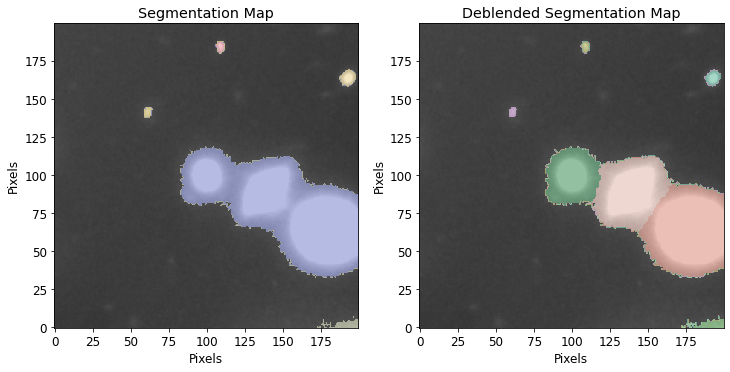

In [32]:
from astropy.stats import sigma_clipped_stats

# Sigma clipped stats
image_mean, image_median, image_stddev = sigma_clipped_stats(image.data, sigma=3)

cat, segm, segm_deblend = pf.make_catalog(
    image=image.data,  # Input image
    threshold=image_stddev*3,  # Detection threshold
    deblend=True,  # Deblend sources?
    npixels=4**2,  # Minimum number of pixels that make up a source
    plot=True, vmax=vmax, vmin=vmin, # Plotting params
    figsize=(12, 6)
)

Display sources catalog as table:

In [33]:
cat.to_table()

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,61.08347174238899,141.05186559012205,None,59,64,138,144,34.0,1.7994370638925237,1.2826901873829257,72.98283673407356,0.7013382917172669,0.010554540902376175,0.026845833286643028,0.0,0.5834723142907023,nan,1.8317878434947907,nan
2,192.36299560404697,163.40391871827393,None,187,197,158,169,86.0,2.3144983589944554,1.9834471217713212,53.655204869988644,0.5153724293039628,0.010591089725494385,0.0929785966873169,0.0,2.8758262349292636,nan,3.270753741333536,nan
3,108.72693550508657,183.8851479597333,None,106,111,180,187,37.0,1.8003927404449662,1.257057560548163,-87.14736406479223,0.7158901102937193,0.010464809834957123,0.045437149703502655,0.0,0.8372195269912481,nan,1.0690440471675258,nan
4,176.59884904430535,1.7105077906435575,None,172,181,0,5,22.0,2.5652493504083584,1.2345618770639404,13.128240218386496,0.876575763829376,0.010684505105018616,0.01434874627739191,0.0,0.26085690688341856,nan,3.4444912086638304,nan
5,192.09296727764394,1.82553577948899,None,180,199,0,7,84.0,4.976606287872485,1.54229392874648,5.980651162675712,0.9507662987626069,0.010602000169456005,0.02371048368513584,0.0,1.247399945743382,nan,3.5905737116101784,nan
6,178.73633119059068,63.493826518219336,None,143,199,33,95,2704.0,9.40299866437019,9.177157386885888,-48.66212288913641,0.21785120428951427,0.010437765158712864,3.6771397590637207,0.0,421.7741427142173,nan,422.68155565524626,nan
7,138.55898473281684,89.25004484979968,None,109,166,63,112,1864.0,7.532153967377171,5.563519557842017,44.31309259442659,0.6741045627289916,0.010432953014969826,3.6545557975769043,0.0,244.33296140562743,nan,240.57513423073874,nan
8,99.92859014542458,99.15188824983441,None,83,118,80,118,1114.0,6.7507255757709,6.379388610260266,76.60826994576462,0.3270904691538552,0.010427203960716724,0.44580602645874023,0.0,56.775723142549396,nan,60.326006697224265,nan


## Curve of Growth and Petrosian Radii

This step in detailed in the [Photometry](./photometry.ipynb#Photometry) and [Petrosian](./petrosian.ipynb#Petrosian) sections but we will do a simple example here. The first step is to pick a source from the catalog we made in the last step:

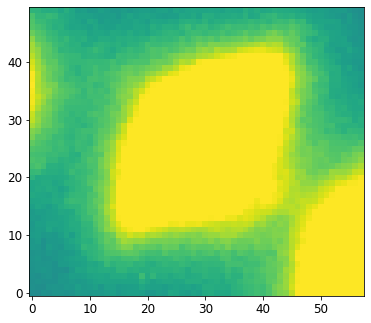

In [34]:
source = cat[6]

# Photutils cutout of the source
# Not to be confused with the cutout we made
plt.imshow(source.data, vmin=vmin, vmax=vmax)
plt.show()

Now we use PetroFit `source_photometry` to compute the curve of growth

7


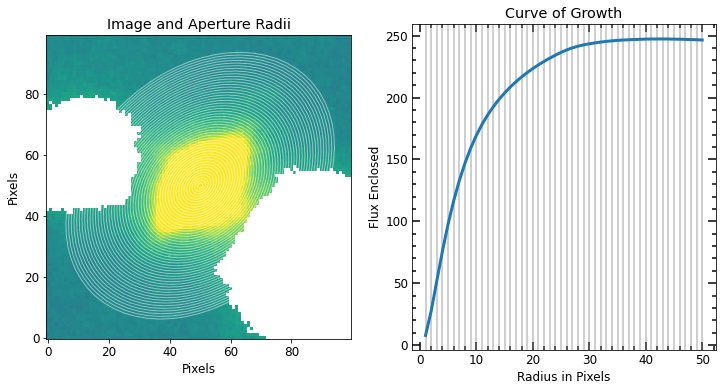

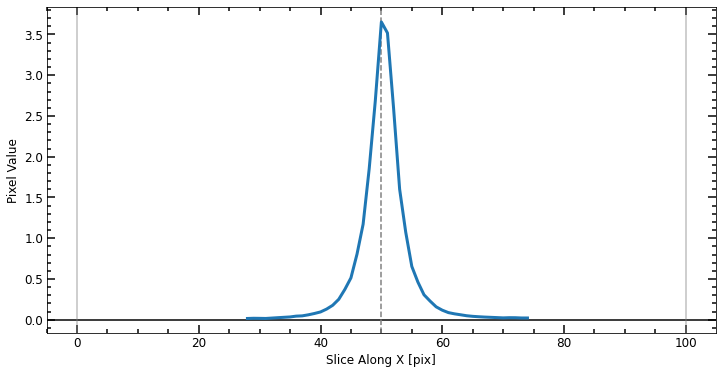

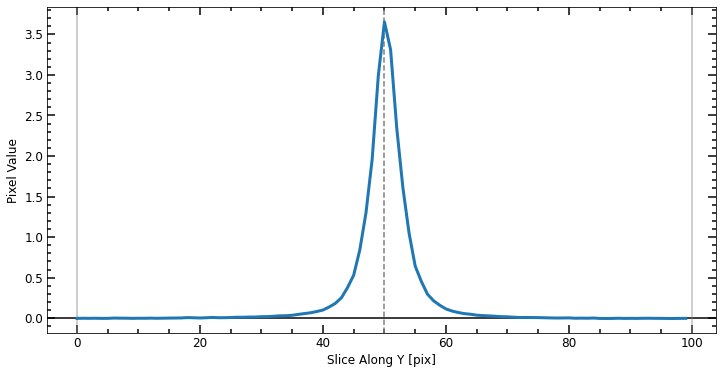

In [35]:
r_list = pf.make_radius_list(
    max_pix=50, # Max pixel to go up to
    n=50 # the number of radii to produce
)

# Photomerty
flux_arr, area_arr, error_arr = pf.source_photometry(

    # Inputs
    source, # Source (`photutils.segmentation.catalog.SourceCatalog`)
    image.data, # Image as 2D array
    segm_deblend, # Deblended segmentation map of image
    r_list, # list of aperture radii

    # Options
    cutout_size=max(r_list)*2, # Cutout out size, set to double the max radius
    bg_sub=True, # Subtract background
    sigma=3, sigma_type='clip', # Fit a 2D plane to pixels within 3 sigma of the mean
    plot=True, vmax=vmax, vmin=vmin, # Show plot with max and min defined above
)
plt.show()

Now we have a radius list (`r_list`) and a corresponding enclosed flux list (`flux_arr`), we can plot the curve of growth and initialize a `Petrosian` profile

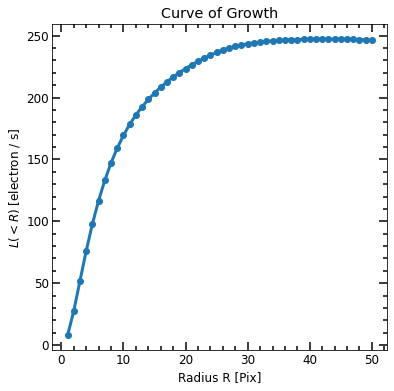

In [36]:
plt.plot(r_list, flux_arr, linewidth=3, marker='o')

pf.mpl_tick_frame()

plt.title("Curve of Growth")
plt.xlabel("Radius R [Pix]")
plt.ylabel("$L(<R)$ [{}]".format(image.unit))
plt.show()

We now define the `Petrosian` using the curve of growth arrays and inspect various radii:

In [37]:
p = pf.Petrosian(r_list, area_arr, flux_arr)

print(p.r_half_light, p.r_total_flux, p.r_petrosian, p.c2080)

6.361672334466893 30.02360472094419 15.013002600520105 3.376753454810066


The radii can be plotted as follows:

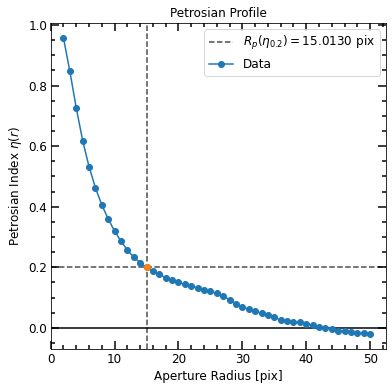

In [38]:
# Plot Petrosian
p.plot(plot_r=True)
plt.show()